Setup

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv')  # path to your downloaded file
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Text Preprocessing

In [ ]:
!pip install -q spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 103.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load('en_core_web_sm')

def spacy_preprocess(text):
    doc = nlp(text.lower())  # lowercase
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)


In [ ]:
# Assuming your DataFrame is named df and review column is 'review'
df['cleaned_review'] = df['review'].apply(spacy_preprocess)

print(df[['review', 'cleaned_review']].head())


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  reviewer mention watch oz episode hook right e...  
1  wonderful little production br filming techniq...  
2  think wonderful way spend time hot summer week...  
3  basically family little boy jake think zombie ...  
4  petter mattei love time money visually stunnin...  


Feature Extraction & Model Training


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # unigrams and bigrams

# Fit and transform the cleaned reviews
X = tfidf.fit_transform(df['cleaned_review'])

print(f"TF-IDF matrix shape: {X.shape}")


TF-IDF matrix shape: (50000, 5000)


In [ ]:
# Map sentiment labels to binary values
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

y = df['sentiment_label']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy: 0.8827


Prepare Target Variable & Train-Test Split

In [ ]:
# Map sentiment to binary labels: positive=1, negative=0
df['sentiment_label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Check the distribution
print(df['sentiment_label'].value_counts())


sentiment_label
1    25000
0    25000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# X is your TF-IDF features matrix, y is the label vector
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 40000
Testing samples: 10000


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy: 0.8827


Model Evaluation


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Accuracy: 0.8827


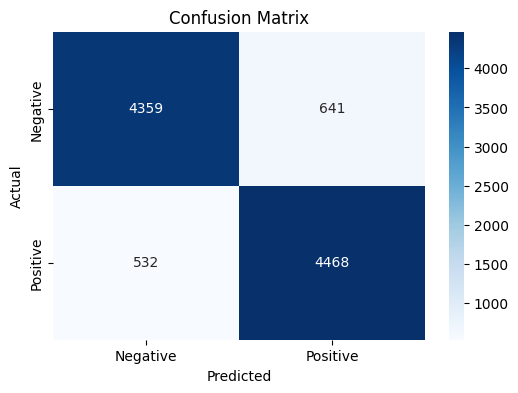

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


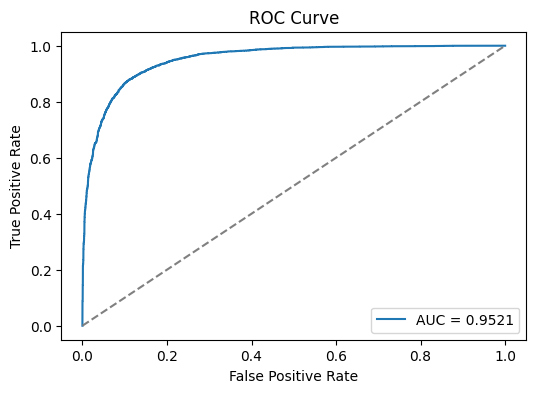

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Hyperparameter Tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', None],  # None instead of 'none'
    'solver': ['saga'],  # saga supports all these penalties
    'max_iter': [100, 200, 500],
    'l1_ratio': [0, 0.5, 1]  # Required only if penalty='elasticnet'
}


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings

# Define parameter grid without invalid combinations
param_grid = [
    {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['saga'], 'max_iter': [200]},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10], 'solver': ['saga'], 'max_iter': [200], 'l1_ratio': [0.5]},
    {'penalty': [None], 'C': [0.01, 0.1, 1, 10], 'solver': ['saga'], 'max_iter': [200]}
]

logreg = LogisticRegression()

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, error_score='raise')

# Suppress convergence warnings if you want
warnings.filterwarnings("ignore", category=ConvergenceWarning)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation accuracy: 0.8799499999999998


In [28]:
print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Hyperparameters: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
Test Accuracy: 0.8838
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.90      0.89      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Trying More Advanced Models

In [29]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

models = {
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(max_iter=10000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"--- {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))


--- Naive Bayes ---
Accuracy: 0.8511
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5000
           1       0.84      0.87      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

--- Linear SVM ---
Accuracy: 0.8743
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      5000
           1       0.87      0.88      0.88      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

--- Random Forest ---
Accuracy: 0.8444
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      5000
           1       0.85      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg    

In [30]:
#LSTM
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
max_words = 10000  # vocabulary size
max_len = 200      # max sequence length

# Tokenize text (use raw reviews or cleaned reviews)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['review'])

X_seq = tokenizer.texts_to_sequences(df['review'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Split train/test again for deep learning
from sklearn.model_selection import train_test_split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, df['sentiment_label'], test_size=0.2, random_state=42, stratify=df['sentiment_label'])

# Build LSTM model
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train with early stopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es])

# Evaluate
loss, accuracy = model.evaluate(X_test_dl, y_test_dl)
print(f"LSTM Test Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 161s 312ms/step - accuracy: 0.7224 - loss: 0.5297 - val_accuracy: 0.7906 - val_loss: 0.4430
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 203s 314ms/step - accuracy: 0.8590 - loss: 0.3410 - val_accuracy: 0.8597 - val_loss: 0.3317
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 315ms/step - accuracy: 0.8958 - loss: 0.2657 - val_accuracy: 0.8704 - val_loss: 0.3131
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 160s 321ms/step - accuracy: 0.9106 - loss: 0.2308 - val_accuracy: 0.8649 - val_loss: 0.3252
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 202s 321ms/step - accuracy: 0.9312 - loss: 0.1838 - val_accuracy: 0.8611 - val_loss: 0.3365
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 204s 324ms/step - accuracy: 0.9421 - loss: 0.1559 - val_accuracy: 0.8615 - val_loss: 0.3675
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8780 - loss: 0.3100
LSTM Test Accuracy: 0.8788


Error Analysis

In [31]:
import pandas as pd

# Predict on test set using your best model (e.g., Logistic Regression or LSTM)
y_pred = best_model.predict(X_test)  # replace best_model with your chosen model

# Create a DataFrame with actual, predicted, and review text
results_df = pd.DataFrame({
    'review': df.loc[y_test.index, 'review'],  # original reviews corresponding to test set
    'actual': y_test,
    'predicted': y_pred
})

# Filter misclassified samples
misclassified = results_df[results_df['actual'] != results_df['predicted']]

print(f"Number of misclassified samples: {len(misclassified)}")
print(misclassified.head(10))


Number of misclassified samples: 1162
                                                  review  actual  predicted
40882  This movie is really wack. There is really not...       0          1
41611  I admit creating great expectations before wat...       1          0
40714  Little Quentin seems to have mastered the art ...       0          1
31882  The film listed here as having been made in 19...       0          1
1591   This is not a GREAT movie as tho the cast (esp...       1          0
7266   Farrah Fawcett gives an award nominated perfor...       1          0
11840  I had known Brad Linaweaver at Florida State U...       0          1
20169  I am quite a fan of novelist/screenwriter Mich...       0          1
47706  ... a recommendation! Gloria Grahame runs the ...       0          1
46536  I just can't believe some of the comments on t...       1          0


Feature Engineering

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,3))  # unigrams + bigrams + trigrams
X = tfidf.fit_transform(df['review'])

# Then split and train your model again as before


In [36]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

from scipy.sparse import hstack
import numpy as np

length_feature = np.array(df['review_length']).reshape(-1, 1)

# After splitting train/test for X and y:
X_train_len = length_feature[y_train.index]
X_test_len = length_feature[y_test.index]

X_train_combined = hstack([X_train, X_train_len])
X_test_combined = hstack([X_test, X_test_len])

# Train model with combined features
model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train)

y_pred = model.predict(X_test_combined)
print("Accuracy with review length:", accuracy_score(y_test, y_pred))


Accuracy with review length: 0.883


In [37]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df['vader_compound'] = df['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Add this feature as numeric alongside TF-IDF features (similar to review length)
vader_feature = np.array(df['vader_compound']).reshape(-1, 1)

X_train_vader = vader_feature[y_train.index]
X_test_vader = vader_feature[y_test.index]

X_train_combined = hstack([X_train, X_train_vader])
X_test_combined = hstack([X_test, X_test_vader])

model.fit(X_train_combined, y_train)
y_pred = model.predict(X_test_combined)
print("Accuracy with VADER feature:", accuracy_score(y_test, y_pred))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00
Accuracy with VADER feature: 0.8837


Cross-Validation for Robust Model Evaluation

In [38]:
from sklearn.model_selection import cross_val_score

# Use your best model (e.g., LogisticRegression, SVM, etc.)
# X and y should be your full feature matrix and label vector
scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print("Cross-validation accuracy scores:", scores)
print(f"Mean accuracy: {scores.mean():.4f}")
print(f"Standard deviation: {scores.std():.4f}")


Cross-validation accuracy scores: [0.8921 0.8873 0.8876 0.8869 0.8845]
Mean accuracy: 0.8877
Standard deviation: 0.0025


In [39]:
f1_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1', n_jobs=-1)
print("Cross-validation F1 scores:", f1_scores)
print(f"Mean F1-score: {f1_scores.mean():.4f}")


Cross-validation F1 scores: [0.89336493 0.88851518 0.88877894 0.88851651 0.88510892]
Mean F1-score: 0.8889


Model Deployment

In [40]:
import joblib

# Save the model
joblib.dump(best_model, 'sentiment_model.joblib')

# Save the TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']

In [41]:
import joblib

# Load model and vectorizer
loaded_model = joblib.load('sentiment_model.joblib')
loaded_vectorizer = joblib.load('tfidf_vectorizer.joblib')

# Example: Predict sentiment for a new review
new_review = ["This movie was absolutely fantastic and thrilling!"]
new_review_tfidf = loaded_vectorizer.transform(new_review)
prediction = loaded_model.predict(new_review_tfidf)

print("Predicted sentiment:", "positive" if prediction[0] == 1 else "negative")


Predicted sentiment: positive
